In [1]:
%matplotlib inline

import anndata
import glob
import matplotlib
from matplotlib import pyplot
import numpy
import pandas
import scanpy as sc
import seaborn
import sys

print(f'Package versions:\nPython {sys.version}, '
      f'anndata {anndata.__version__}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, scanpy {sys.modules["scanpy"].__version__}, '
      f'seaborn {seaborn.__version__}')

Package versions:
Python 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:08:06) [GCC 11.3.0], anndata 0.9.1, matplotlib 3.7.1, numpy 1.23.5, pandas 2.0.0, scanpy 1.9.3, seaborn 0.12.2


In [2]:
prot_data = pandas.read_csv('./tmt_proteome_proteinquant.csv')
prot_data.drop(columns='Unnamed: 20', inplace=True)
print(prot_data.shape)
prot_data.head()

(8156, 20)


,ProteinID,GeneSymbol,Description,Peptides,normoxia_mono_1,normoxia_mono_2,normoxia_mono_3,normoxia_mono_4,normoxia_PFF_1,normoxia_PFF_2,normoxia_PFF_3,normoxia_PFF_4,hypoxia_mono_1,hypoxia_mono_2,hypoxia_mono_3,hypoxia_mono_4,hypoxia_PFF_1,hypoxia_PFF_2,hypoxia_PFF_3,hypoxia_PFF_4
0,P52480-2,Pkm,Isoform M1 of Pyruvate kinase PKM,52,13397.10,15033.80,15082.20,13905.8,14342.60,14181.80,16009.20,14462.3,13597.3,14979.3,14093.2,14476.2,14401.3,14374.1,10409.20,14950.2
1,P62814,Atp6v1b2,"V-type proton ATPase subunit B, brain isoform",52,12389.00,13216.80,13089.60,12775.5,13217.10,13033.70,13329.10,12735.5,12369.8,12576.4,13115.5,12733.7,12933.8,12663.5,10090.20,13405.6
2,Q02053,Uba1,Ubiquitin-like modifier-activating enzyme 1,50,17452.00,17929.40,17077.40,17062.4,17809.00,17943.70,17315.50,16938.8,15882.8,16892.1,16828.0,16115.6,16759.3,17043.3,13105.90,16937.1
3,P68369,Tuba1a,Tubulin alpha-1A chain,45,15953.70,15629.60,14548.70,14927.9,15452.40,15433.80,14369.00,13824.1,13833.5,14273.2,15114.8,13344.6,14761.4,14744.9,8379.74,14190.5
4,P02088,Hbb-b1,Hemoglobin subunit beta-1,44,7966.89,8476.08,9521.08,11679.0,9199.57,7897.93,9509.57,15231.3,19869.7,27909.5,20028.4,30447.3,15399.1,16189.9,38032.10,25463.1


In [3]:
protein_info_cols = ['ProteinID', 'GeneSymbol', 'Description', 'Peptides']
mouse_data_cols = [elt for elt in prot_data.columns.values if elt not in protein_info_cols]

In [4]:
mouse_metadata = pandas.Series(mouse_data_cols, name='mouse_id').to_frame()
mouse_metadata[['o2_status', 'monomer_or_pff', 'rep']] = mouse_metadata['mouse_id'].str.split('_', expand=True)
mouse_metadata['exp_condition'] = mouse_metadata['o2_status'] + '_' + mouse_metadata['monomer_or_pff']
#mouse_metadata = mouse_metadata.set_index('mouse_id', drop=False)

print(mouse_metadata.shape)
mouse_metadata.head()

(16, 5)


,mouse_id,o2_status,monomer_or_pff,rep,exp_condition
0,normoxia_mono_1,normoxia,mono,1,normoxia_mono
1,normoxia_mono_2,normoxia,mono,2,normoxia_mono
2,normoxia_mono_3,normoxia,mono,3,normoxia_mono
3,normoxia_mono_4,normoxia,mono,4,normoxia_mono
4,normoxia_PFF_1,normoxia,PFF,1,normoxia_PFF


In [5]:
addl_metadata = (pandas.read_csv('20231130_Proteomics_sample_list.csv')
                 .rename(columns={'harvest date':'Harvest date', 'Cage test latency (s)':'Cage test latency (sec)'}))
print(addl_metadata.shape)
addl_metadata.head()

(16, 7)


,Sample ID,Treatment,Injection,Injection date,Harvest date,Pole test latency (sec),Cage test latency (sec)
0,P1,normoxia,monomer,8/19/2023,11/30/2023,4.200000,92.53333
1,P2,normoxia,monomer,8/19/2023,11/30/2023,5.833333,50.43333
2,P3,normoxia,monomer,8/20/2023,11/30/2023,6.966667,55.16667
3,P4,normoxia,monomer,8/20/2023,11/30/2023,7.300000,62.30000
4,P5,normoxia,PFF,8/19/2023,11/29/2023,8.933333,89.43333


In [6]:
cols_to_add = ['Injection date', 'Harvest date', 'Pole test latency (sec)', 'Cage test latency (sec)']
mouse_metadata[cols_to_add] = addl_metadata[cols_to_add]
mouse_metadata = mouse_metadata.set_index('mouse_id', drop=False)
print(mouse_metadata.shape)
mouse_metadata.head()

(16, 9)


,mouse_id,o2_status,monomer_or_pff,rep,exp_condition,Injection date,Harvest date,Pole test latency (sec),Cage test latency (sec)
mouse_id,,,,,,,,,
normoxia_mono_1,normoxia_mono_1,normoxia,mono,1,normoxia_mono,8/19/2023,11/30/2023,4.200000,92.53333
normoxia_mono_2,normoxia_mono_2,normoxia,mono,2,normoxia_mono,8/19/2023,11/30/2023,5.833333,50.43333
normoxia_mono_3,normoxia_mono_3,normoxia,mono,3,normoxia_mono,8/20/2023,11/30/2023,6.966667,55.16667
normoxia_mono_4,normoxia_mono_4,normoxia,mono,4,normoxia_mono,8/20/2023,11/30/2023,7.300000,62.30000
normoxia_PFF_1,normoxia_PFF_1,normoxia,PFF,1,normoxia_PFF,8/19/2023,11/29/2023,8.933333,89.43333


In [7]:
var_metadata = prot_data[protein_info_cols].copy()
var_metadata = var_metadata.set_index('ProteinID', drop=False)

print(var_metadata.shape)
var_metadata.head()

(8156, 4)


,ProteinID,GeneSymbol,Description,Peptides
ProteinID,,,,
P52480-2,P52480-2,Pkm,Isoform M1 of Pyruvate kinase PKM,52
P62814,P62814,Atp6v1b2,"V-type proton ATPase subunit B, brain isoform",52
Q02053,Q02053,Uba1,Ubiquitin-like modifier-activating enzyme 1,50
P68369,P68369,Tuba1a,Tubulin alpha-1A chain,45
P02088,P02088,Hbb-b1,Hemoglobin subunit beta-1,44


In [8]:
prot_data = prot_data.set_index('ProteinID', drop=False)
anndata_obj = anndata.AnnData(X=prot_data[mouse_data_cols].copy().T,
                              obs=mouse_metadata,
                              var=var_metadata)
print(anndata_obj)

AnnData object with n_obs × n_vars = 16 × 8156
    obs: 'mouse_id', 'o2_status', 'monomer_or_pff', 'rep', 'exp_condition', 'Injection date', 'Harvest date', 'Pole test latency (sec)', 'Cage test latency (sec)'
    var: 'ProteinID', 'GeneSymbol', 'Description', 'Peptides'


In [9]:
anndata_obj.var['GeneID'] = anndata_obj.var['GeneSymbol'] + '_' + anndata_obj.var['ProteinID'] + '_' + anndata_obj.var['Peptides'].astype(str)
anndata_obj.var = anndata_obj.var.set_index('GeneID')

In [10]:
anndata_obj.layers['data_norm'] = anndata_obj.X.copy()
sc.pp.log1p(anndata_obj)
anndata_obj.layers['data_lognorm'] = anndata_obj.X.copy()

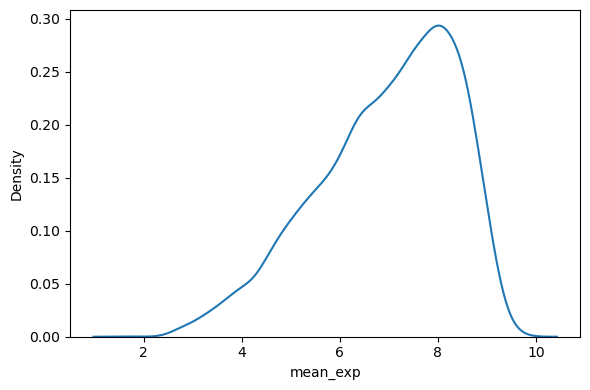

In [11]:
anndata_obj.var['mean_exp'] = anndata_obj.X.mean(axis=0)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
seaborn.kdeplot(data=anndata_obj.var, x='mean_exp', ax=axes)
fig.tight_layout()

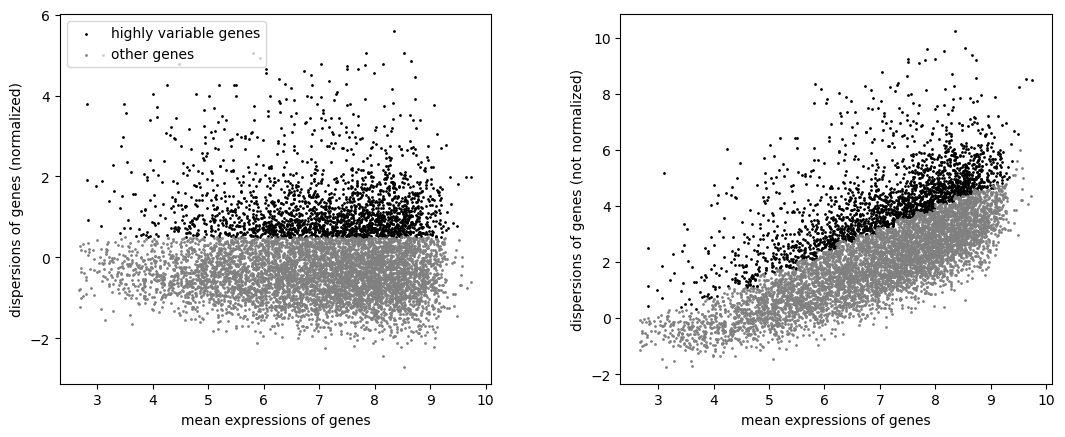

Found 2119 HV genes.


In [12]:
sc.pp.highly_variable_genes(anndata_obj, min_mean=0, max_mean=10, min_disp=0.5)
sc.pl.highly_variable_genes(anndata_obj)
print(f'Found {anndata_obj.var["highly_variable"].sum()} HV genes.')

In [13]:
sc.pp.scale(anndata_obj, zero_center=True)
anndata_obj.layers['data_lognorm_scaled'] = anndata_obj.X.copy()

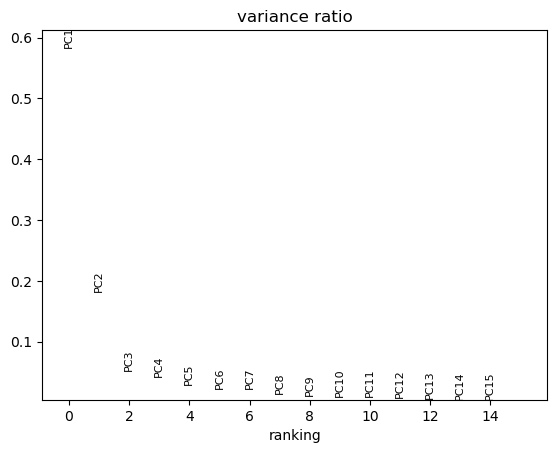

In [14]:
sc.tl.pca(anndata_obj, n_comps=15, random_state=2, use_highly_variable=True)
sc.pl.pca_variance_ratio(anndata_obj, n_pcs=15)

/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/san

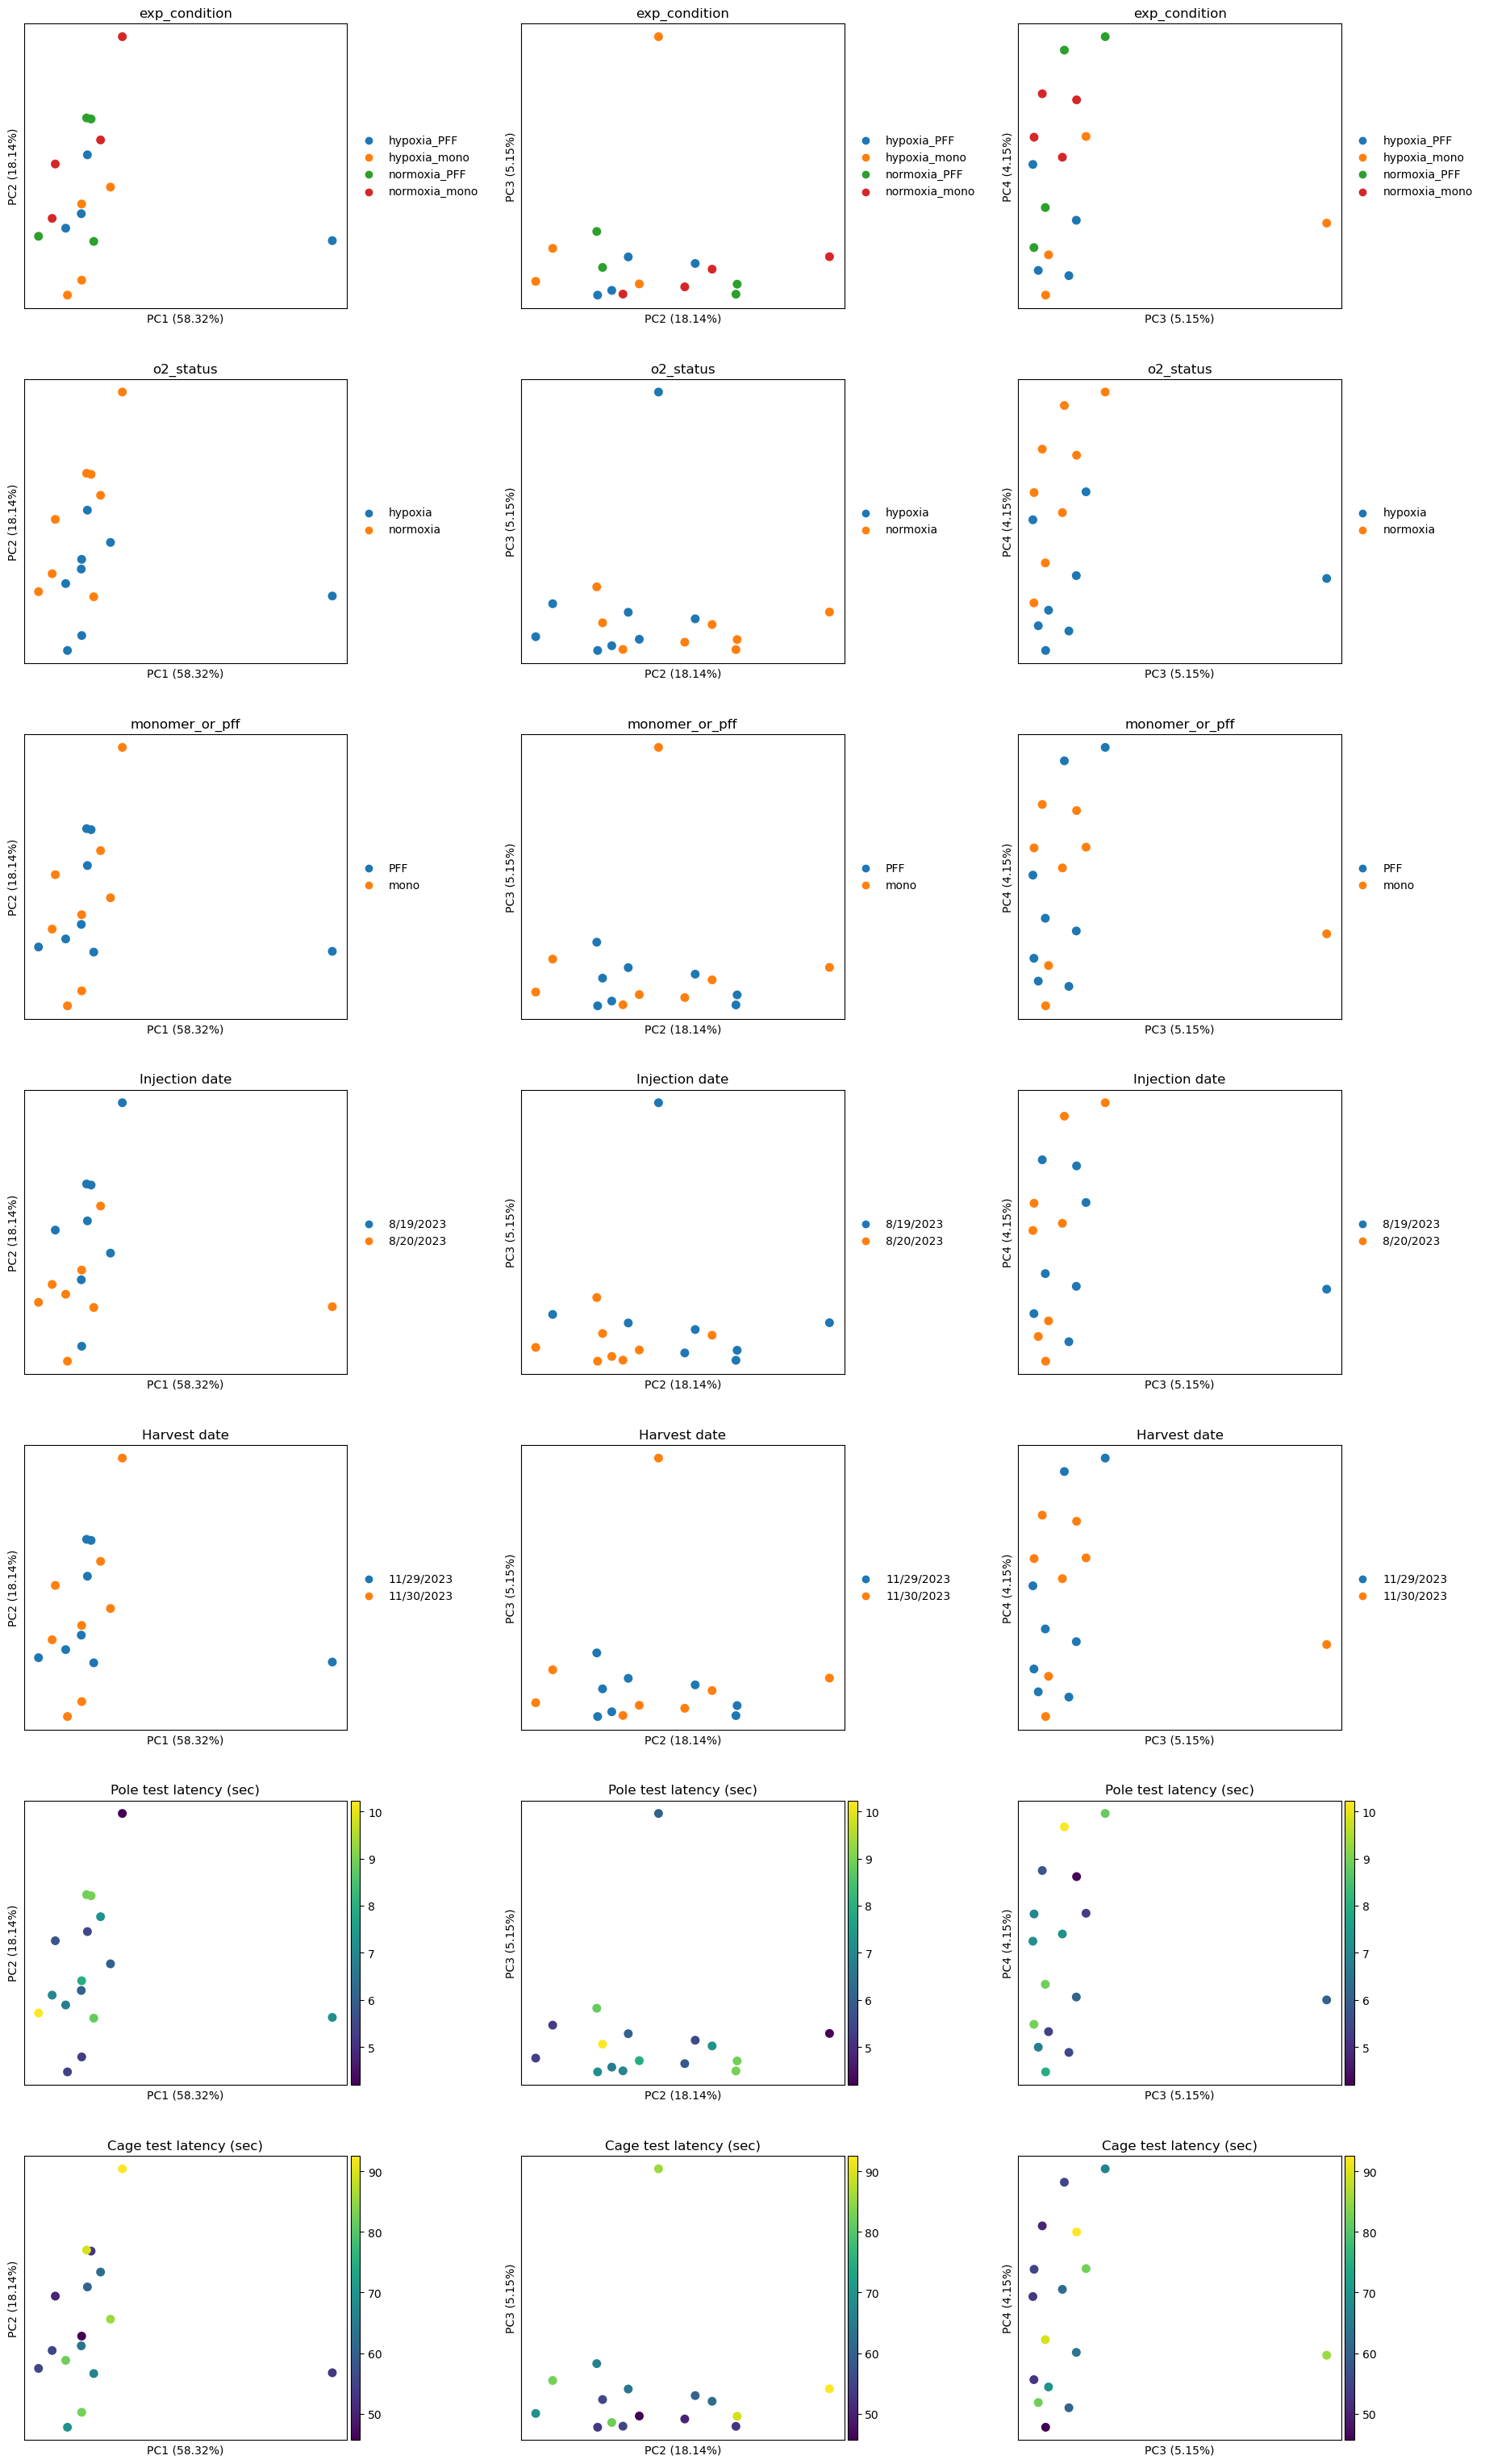

In [15]:
with matplotlib.rc_context({'figure.figsize':(5,5)}):
    sc.pl.pca_scatter(anndata_obj, color=['exp_condition', 'o2_status', 'monomer_or_pff',
                                          'Injection date', 'Harvest date',
                                          'Pole test latency (sec)', 'Cage test latency (sec)'], s=250,
                      components=['1,2', '2,3', '3,4'], ncols=3, wspace=0.4, 
                      annotate_var_explained=True)

In [16]:
#which samples are the outliers?
outlier_ilocs = [numpy.argmax(anndata_obj.obsm['X_pca'][:,0]),
                 numpy.argmax(anndata_obj.obsm['X_pca'][:,1]),
                 numpy.argmax(anndata_obj.obsm['X_pca'][:,2])]
outlier_snames = anndata_obj.obs.iloc[outlier_ilocs]['mouse_id'].values
anndata_obj.obs.iloc[outlier_ilocs]

,mouse_id,o2_status,monomer_or_pff,rep,exp_condition,Injection date,Harvest date,Pole test latency (sec),Cage test latency (sec)
mouse_id,,,,,,,,,
hypoxia_PFF_3,hypoxia_PFF_3,hypoxia,PFF,3,hypoxia_PFF,8/20/2023,11/29/2023,7.200000,52.96667
normoxia_mono_1,normoxia_mono_1,normoxia,mono,1,normoxia_mono,8/19/2023,11/30/2023,4.200000,92.53333
hypoxia_mono_1,hypoxia_mono_1,hypoxia,mono,1,hypoxia_mono,8/19/2023,11/30/2023,6.033333,85.43333


## Remove the outlier samples and proceed with analysis

In [17]:
#remove the outlier and re-do the PCA
anndata_obj.write_h5ad('./tmt_data.all.h5ad', compression='gzip')
anndata_obj = anndata_obj[~anndata_obj.obs.index.isin(outlier_snames)].copy()
anndata_obj.X = anndata_obj.layers['data_lognorm'].copy()
print(anndata_obj)

AnnData object with n_obs × n_vars = 13 × 8156
    obs: 'mouse_id', 'o2_status', 'monomer_or_pff', 'rep', 'exp_condition', 'Injection date', 'Harvest date', 'Pole test latency (sec)', 'Cage test latency (sec)'
    var: 'ProteinID', 'GeneSymbol', 'Description', 'Peptides', 'mean_exp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'exp_condition_colors', 'o2_status_colors', 'monomer_or_pff_colors', 'Injection date_colors', 'Harvest date_colors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'data_norm', 'data_lognorm', 'data_lognorm_scaled'


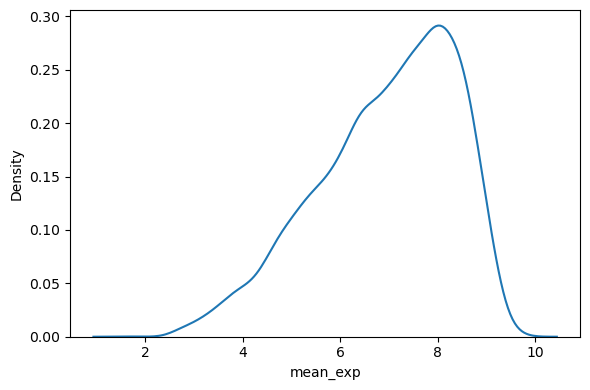

In [18]:
anndata_obj.var['mean_exp'] = anndata_obj.X.mean(axis=0)

fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(6,4))
seaborn.kdeplot(data=anndata_obj.var, x='mean_exp', ax=axes)
fig.tight_layout()

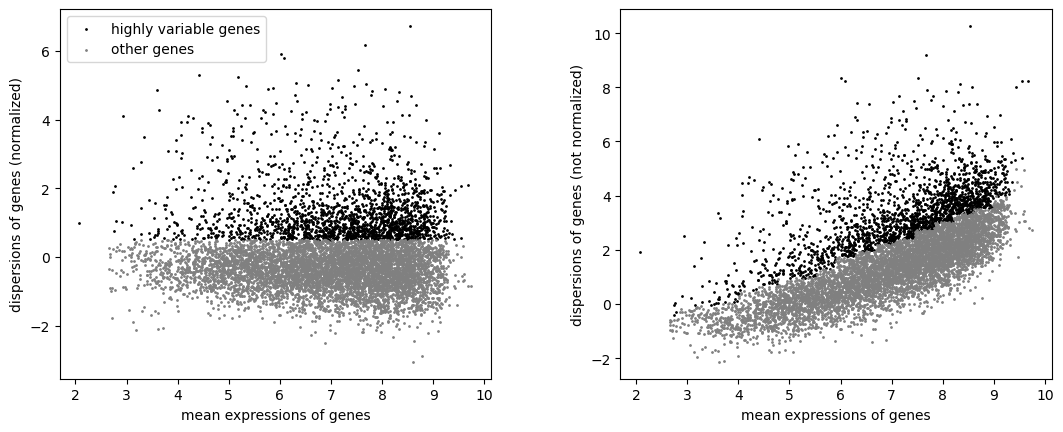

Found 1882 HV genes.


In [19]:
sc.pp.highly_variable_genes(anndata_obj, min_mean=0, max_mean=10, min_disp=0.5)
sc.pl.highly_variable_genes(anndata_obj)
print(f'Found {anndata_obj.var["highly_variable"].sum()} HV genes.')

In [20]:
sc.pp.scale(anndata_obj, zero_center=True)
anndata_obj.layers['data_lognorm_scaled'] = anndata_obj.X.copy()

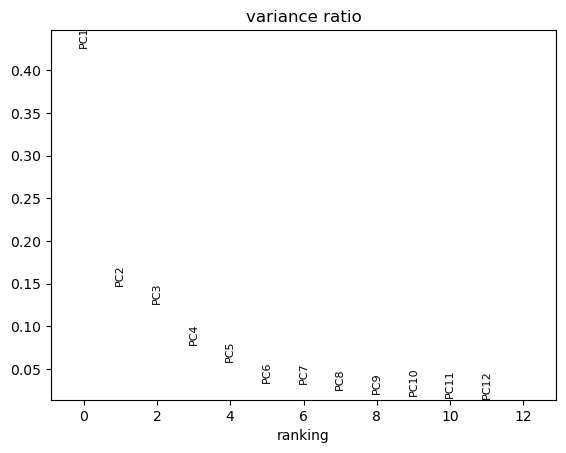

In [21]:
sc.tl.pca(anndata_obj, n_comps=12, random_state=2, use_highly_variable=True)
sc.pl.pca_variance_ratio(anndata_obj, n_pcs=12)

/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/sandbox/tdurham/anaconda/envs/tmt_prot_analysis/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/broad/moothalab/san

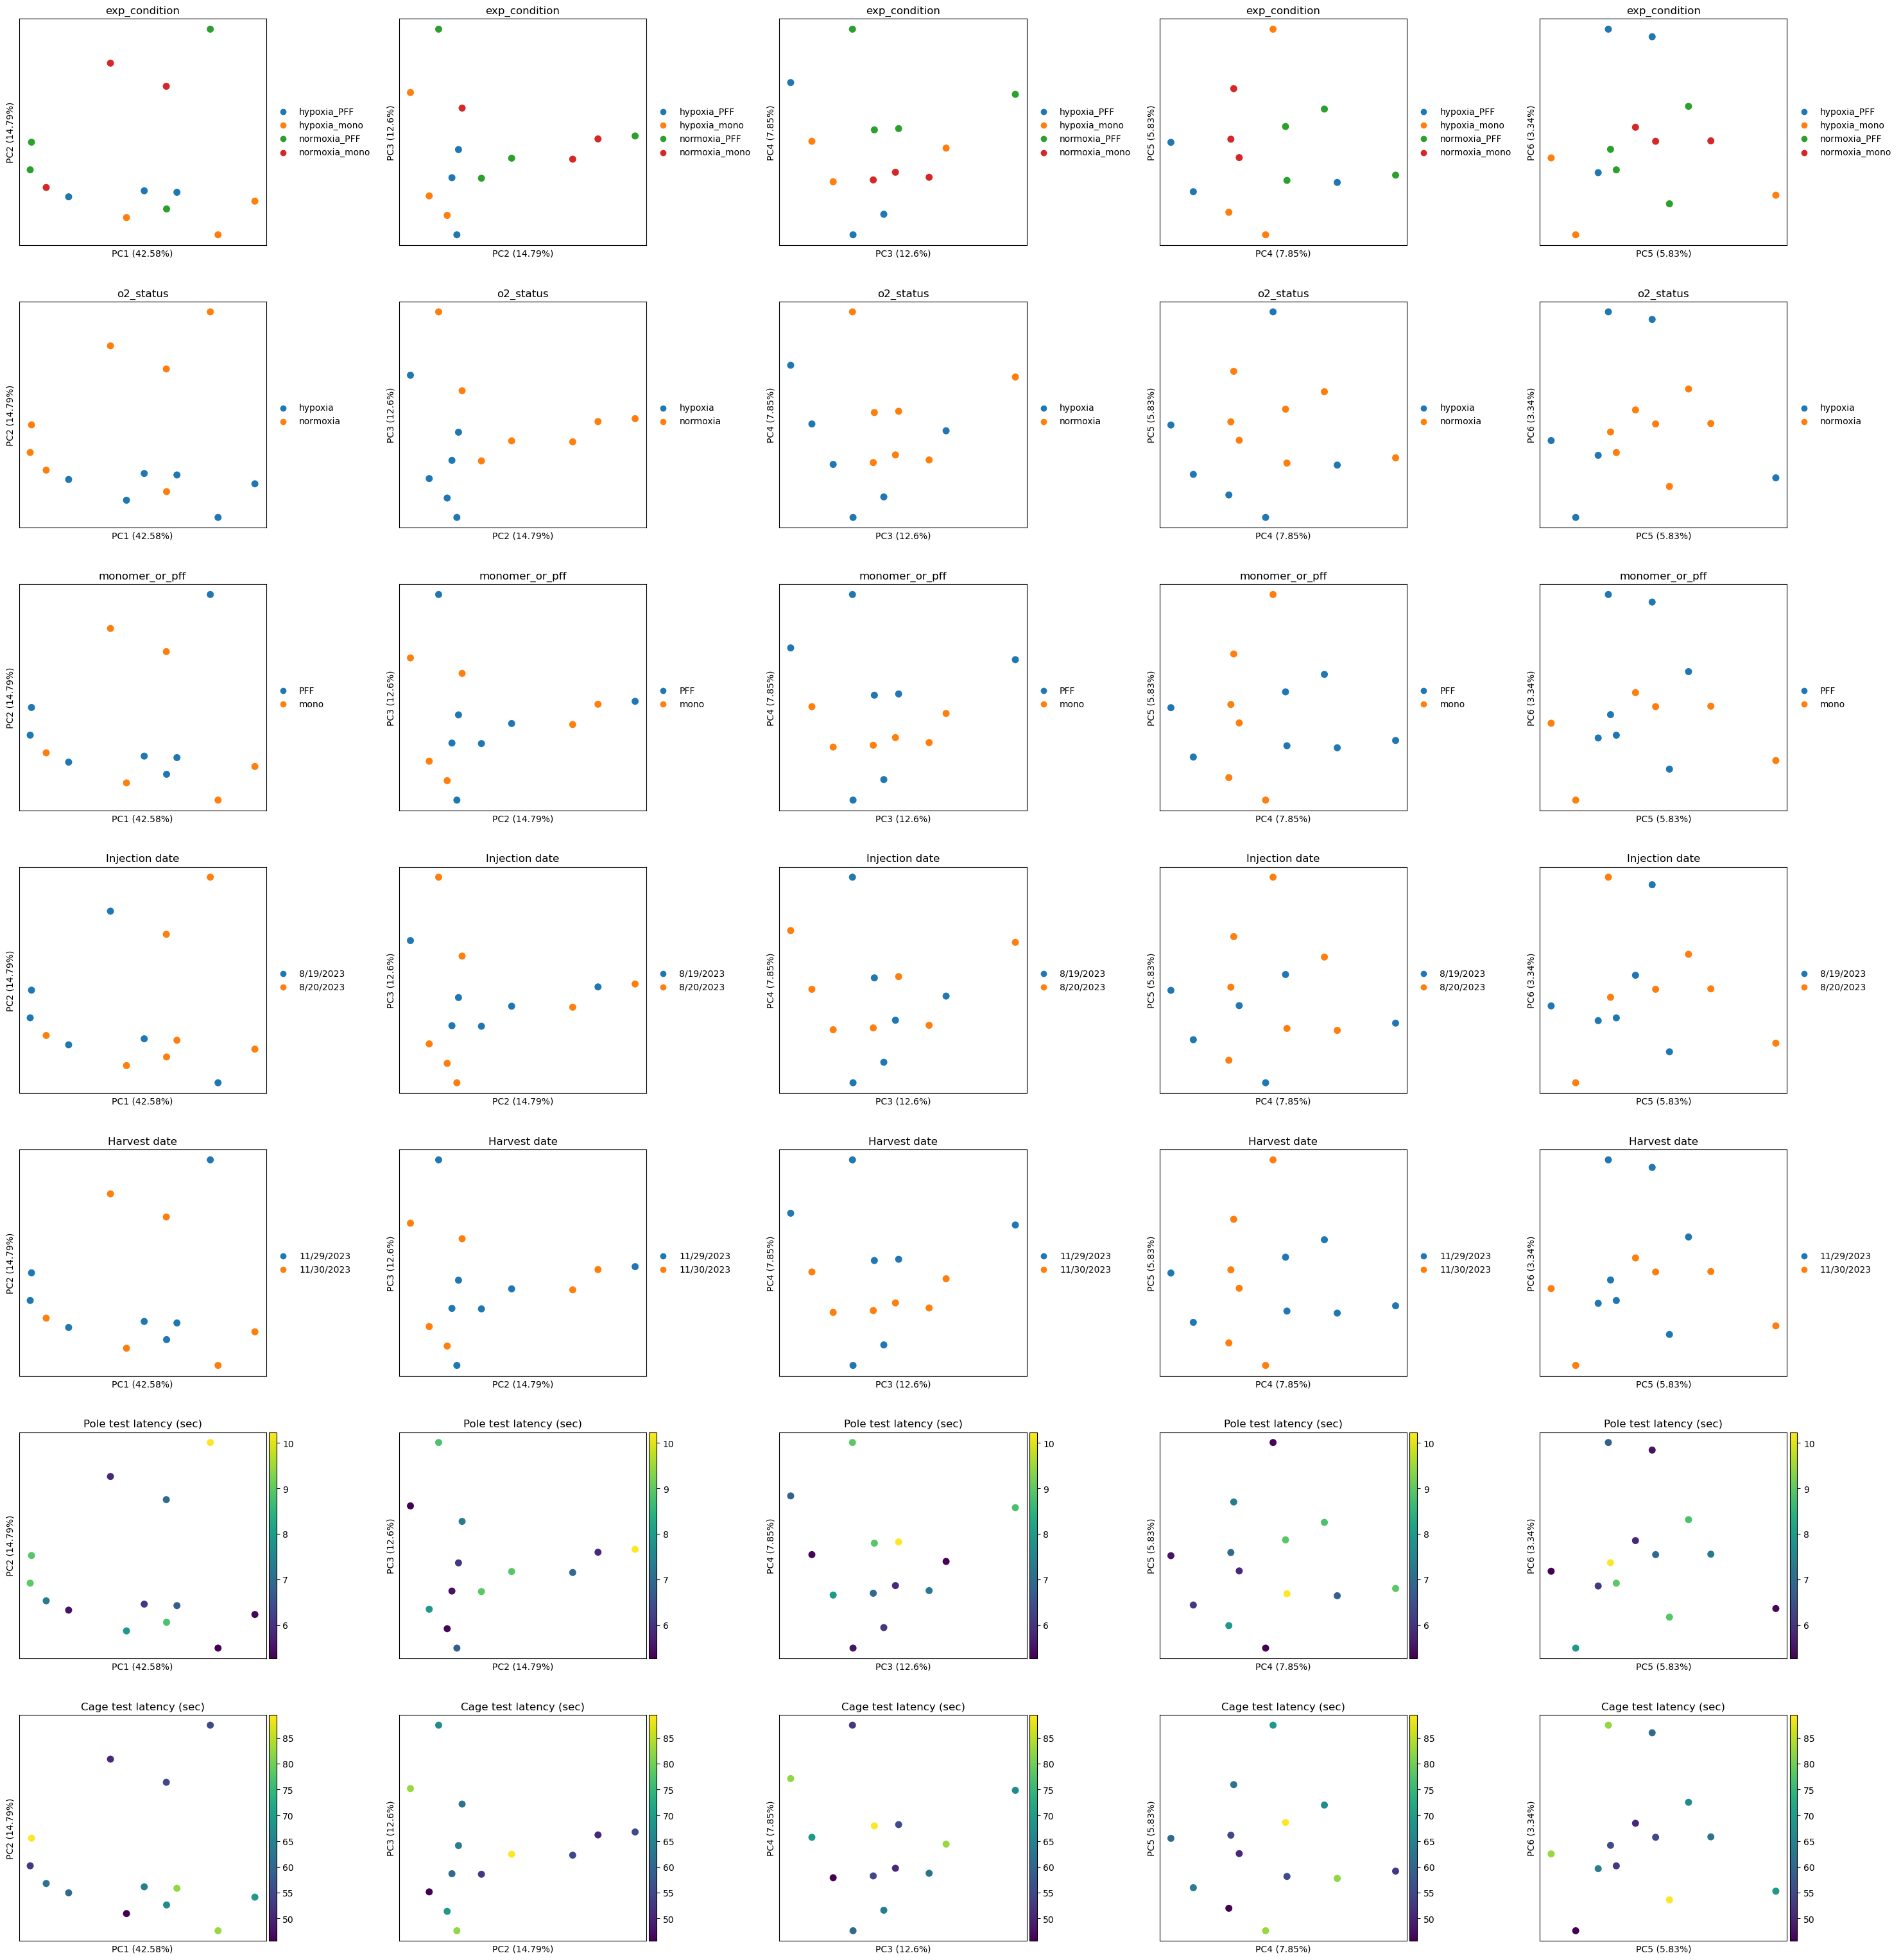

In [22]:
with matplotlib.rc_context({'figure.figsize':(5,5)}):
    sc.pl.pca_scatter(anndata_obj, color=['exp_condition', 'o2_status', 'monomer_or_pff',
                                          'Injection date', 'Harvest date',
                                          'Pole test latency (sec)', 'Cage test latency (sec)'], s=250,
                      components=['1,2', '2,3', '3,4', '4,5', '5,6'], ncols=5, wspace=0.4, 
                      annotate_var_explained=True)

In [23]:
anndata_obj.uns['pca']

{'params': {'zero_center': True, 'use_highly_variable': True},
 'variance': array([801.28533635, 278.30757634, 237.11787238, 147.67174854,
        109.6439339 ,  62.88987502,  61.59842591,  49.02531284,
         40.23919322,  35.63333148,  31.13158776,  27.45580626]),
 'variance_ratio': array([0.42576267, 0.14787863, 0.12599249, 0.07846533, 0.05825926,
        0.03341651, 0.0327303 , 0.02604958, 0.02138108, 0.01893376,
        0.01654176, 0.01458863])}

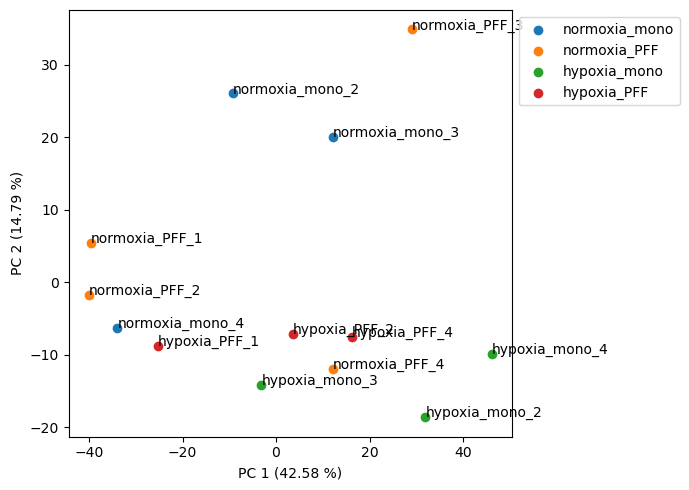

In [24]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(7,5))
for idx, exp_condition in enumerate(anndata_obj.obs['exp_condition'].unique()):
    data_idx = anndata_obj.obs['exp_condition'] == exp_condition
    data_tmp = anndata_obj[data_idx].obsm['X_pca'][:,[0,1]]
    axes.scatter(data_tmp[:,0], data_tmp[:,1], 
                 color=f'C{idx}', label=exp_condition)
    axes.set_xlabel(f'PC 1 ({anndata_obj.uns["pca"]["variance_ratio"][0]*100:0.2f} %)')
    axes.set_ylabel(f'PC 2 ({anndata_obj.uns["pca"]["variance_ratio"][1]*100:0.2f} %)')
    for idx, sname in enumerate(anndata_obj.obs.loc[data_idx, 'mouse_id'].values):
        axes.annotate(sname, (data_tmp[idx,0], data_tmp[idx,1]))
axes.legend(loc='upper left', bbox_to_anchor=[1,1])
fig.tight_layout()

In [25]:
anndata_obj.write_h5ad('./tmt_data.outlier_filt.h5ad', compression='gzip')